# COMS4060A - Introduction of Data Visualisation & Exploration: Assignment 2 

## Group Members
* Lisa Godiwn - 2437980
* Nihal Ranchod - 2427378
* Zach Schwark - 2434346

## Coding Practices

- Dataframe `df` is the original data.
- `df_copy` is a copy of the original dataframe `df` and is used only at the start of the data cleaning process in Question 1.
- `df` used from Question 3 onwards is a new dataframe created by using a cleaned .csv file that is created at the end of Question 2. 

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from datetime import datetime
import optuna
import folium
from folium.plugins import HeatMap
import warnings
import os
warnings.filterwarnings("ignore")

Reading in the .csv and creating a dataframe.


In [91]:
df = pd.read_csv("./nyc_taxis/nyc_taxis.csv")

df_copy = df.copy()
display(df_copy.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


### Question 1: Data Cleaning

Data Exploration: Check for missing values, basic statistics, and unsual data points.

In [92]:
display(df_copy.info())
pd.set_option('display.float_format', '{:.3f}'.format)
display(df_copy.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


None

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [93]:
missing_values = df_copy.isnull().sum()
print(f'Missing values in each column: \n{missing_values}')

Missing values in each column: 
id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64


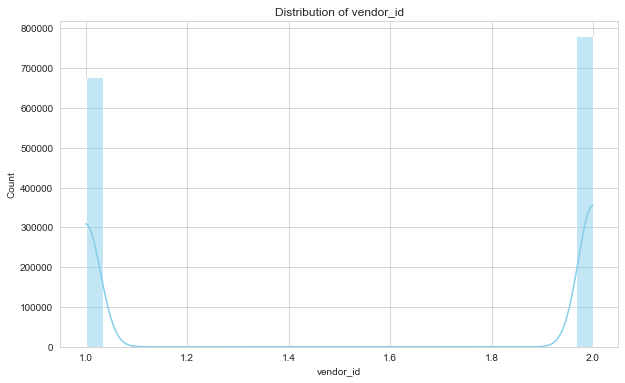

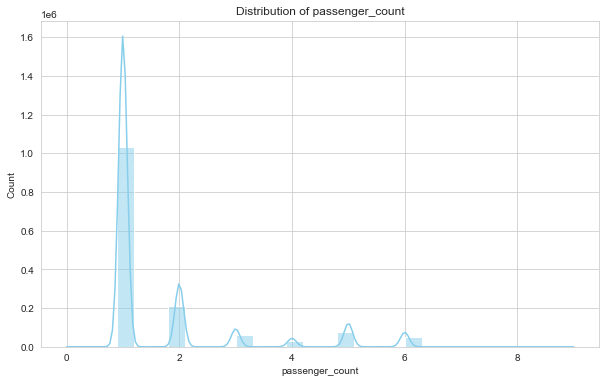

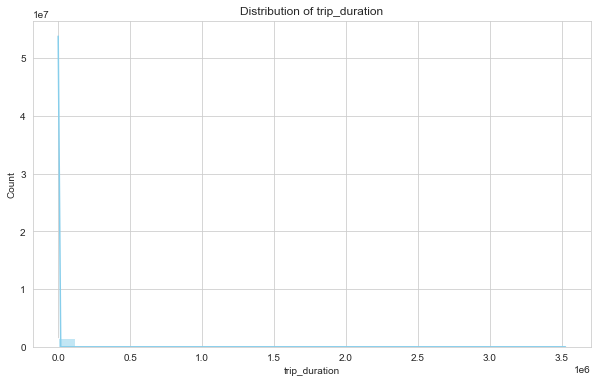

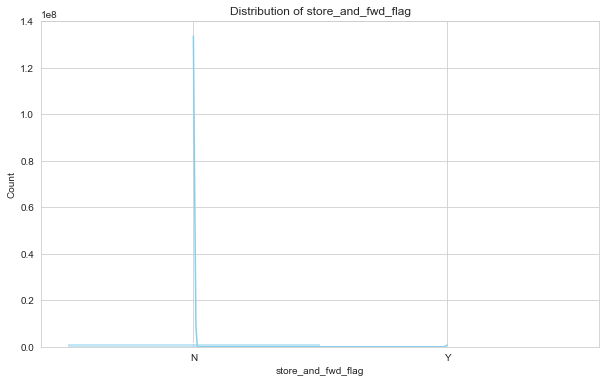

In [94]:
hist_plot_list = ["vendor_id","passenger_count","trip_duration","store_and_fwd_flag"]

output_dir = "./Plots/Plots[1]/"
for column in hist_plot_list:
    plt.figure(figsize=(10, 6))
    sns.histplot(x=df_copy[column], bins=30, color="skyblue", edgecolor=None, kde=True)
    plt.title(f"Distribution of {column}")
    
    # Save the plot to the specified folder
    plot_path = os.path.join(output_dir, f"{column}_distribution.png")
    plt.savefig(plot_path)
    
    # Show the plot
    plt.show()

Trip Duration and Trip Distance Outlier Detection and Removal

In [95]:
# Calculate the distance between pickup and dropoff locations using Haversine formula
def haversine_np(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

df_copy['trip_distance_km'] = haversine_np(df_copy['pickup_longitude'], df_copy['pickup_latitude'], df_copy['dropoff_longitude'], df_copy['dropoff_latitude'])

display(df_copy[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_distance_km']].head())

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_distance_km
0,-73.982,40.768,-73.965,40.766,1.498
1,-73.980,40.739,-73.999,40.731,1.804
2,-73.979,40.764,-74.005,40.710,6.381
3,-74.010,40.720,-74.012,40.707,1.485
4,-73.973,40.793,-73.973,40.783,1.188


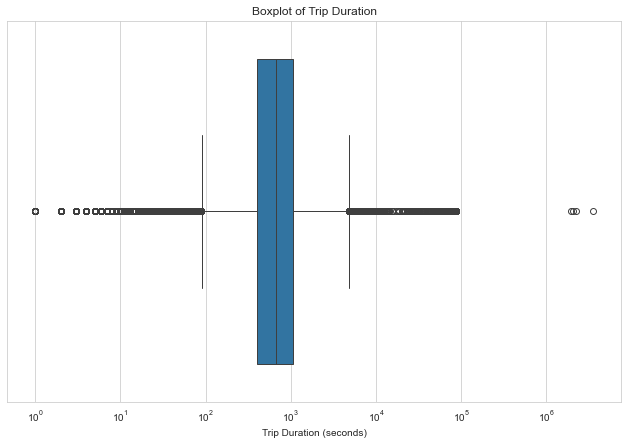

<Figure size 432x288 with 0 Axes>

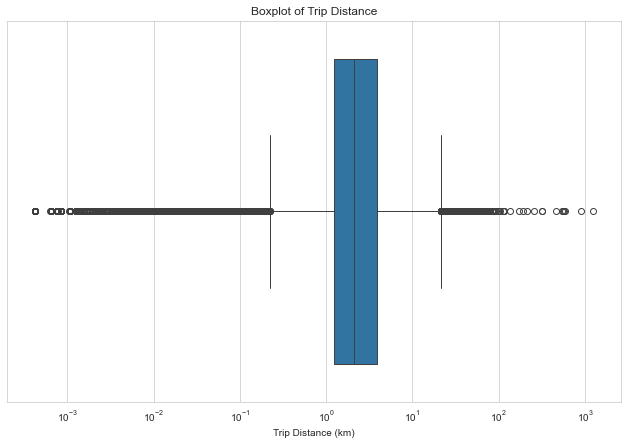

<Figure size 432x288 with 0 Axes>

In [96]:
output_dir = './Plots/Plots[1]'

# List of columns to plot and their labels
plot_info = [
    ("trip_duration", "Trip Duration (seconds)", "Boxplot of Trip Duration", "trip_duration_boxplot.png"),
    ("trip_distance_km", "Trip Distance (km)", "Boxplot of Trip Distance", "trip_distance_boxplot.png")
]

# Set the style for the plots
sns.set_style('whitegrid')

for column, xlabel, title, filename in plot_info:
    plt.figure(figsize=(11, 7))
    sns.boxplot(x=df_copy[column], log_scale=True)
    plt.xlabel(xlabel)
    plt.title(title)
    
    # Save the plot
    plot_path = os.path.join(output_dir, filename)
    plt.savefig(plot_path)
    
    # Show the plot
    plt.show()
    
    # Clear the figure
    plt.clf()

Removing Outliers

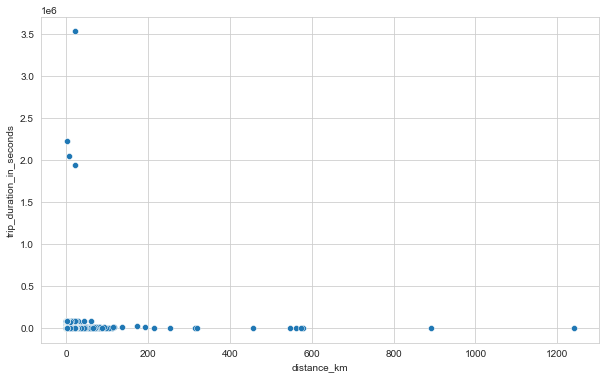

In [97]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_copy["trip_distance_km"],y=df_copy["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot.png')
plt.show()

From the graph, we can see several trips with durations exceeding 1.5 million seconds for distances under 50 kilometers. Since it is highly unlikely that trips covering less than 25 km would take more than 8,000 seconds (approximately 2.2 hours), we have set a conservative threshold at 8,000 seconds to flag these outliers.

The same approach was applied to identify other outliers based on the trends observed in the graph

In [98]:
outliers_in_trip_duration_in_seconds = df_copy[(df_copy["trip_duration"] > 8000) & (df_copy["trip_distance_km"] < 25)]

df_cleaned_1 = df_copy.drop(outliers_in_trip_duration_in_seconds.index, axis=0)

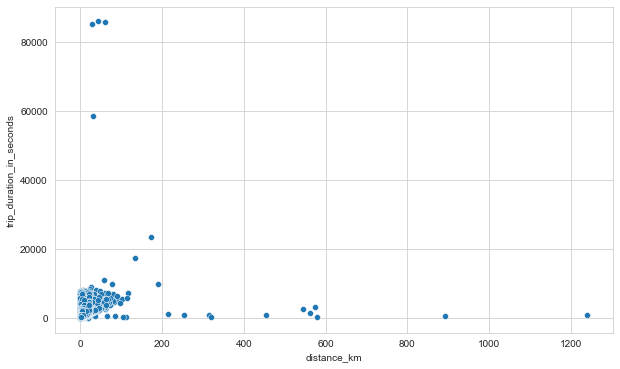

In [99]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_1["trip_distance_km"],y=df_cleaned_1["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_1.png')
plt.show()

In [100]:
outliers_in_trip_duration_in_seconds_2=df_cleaned_1[(df_cleaned_1["trip_duration"] > 30000) & (df_cleaned_1["trip_distance_km"] < 200)]

In [101]:
df_cleaned_2 = df_cleaned_1.drop(outliers_in_trip_duration_in_seconds_2.index, axis=0)

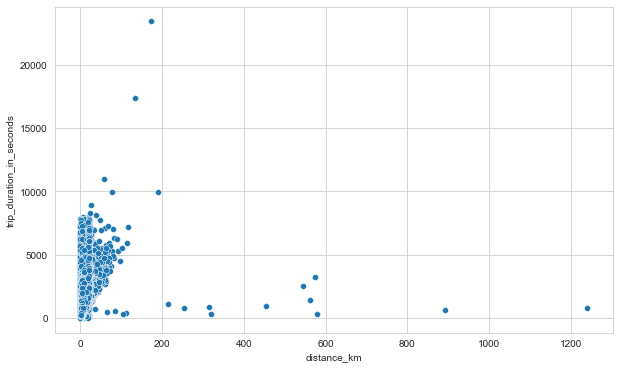

In [102]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_2["trip_distance_km"],y=df_cleaned_2["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_2.png')
plt.show()

In [103]:
outliers_in_trip_duration_in_seconds_3 = df_cleaned_2[(df_cleaned_2["trip_duration"] < 50000) & (df_cleaned_2["trip_distance_km"] > 200)]

In [104]:
df_cleaned_3 = df_cleaned_2.drop(outliers_in_trip_duration_in_seconds_3.index, axis=0)

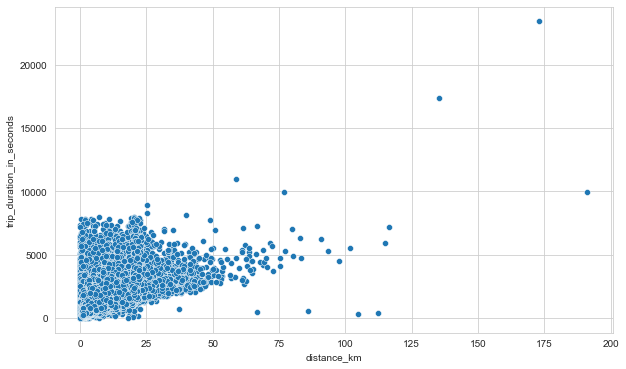

In [105]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_3["trip_distance_km"],y=df_cleaned_3["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.savefig('./Plots/Plots[1]/scatterplot_cleaned_3.png')
plt.show()

In [106]:
outliers_in_trip_duration_in_seconds_4=df_cleaned_3[(df_cleaned_3["trip_duration"] > 0) & (df_cleaned_3["trip_distance_km"] == 0)]

In [107]:
df_cleaned_4 = df_cleaned_3.drop(outliers_in_trip_duration_in_seconds_4.index, axis=0)

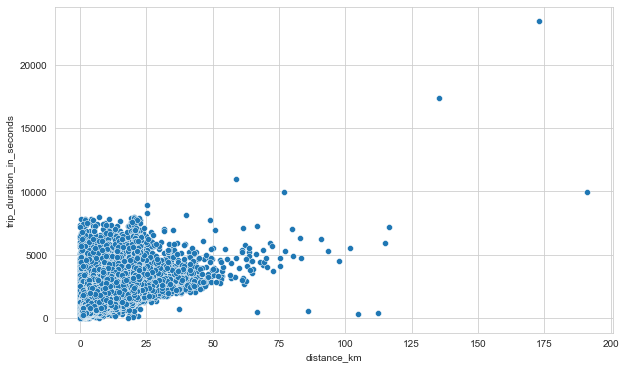

In [108]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_cleaned_4["trip_distance_km"],y=df_cleaned_4["trip_duration"])
plt.xlabel("distance_km")
plt.ylabel("trip_duration_in_seconds")
plt.show()

In [109]:
display(df_cleaned_4)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance_km
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.498
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.804
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.381
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.485
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.188
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982,40.746,-73.995,40.740,N,778,1.224
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.001,40.747,-73.970,40.797,N,655,6.046
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959,40.769,-74.004,40.707,N,764,7.820
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982,40.749,-73.975,40.757,N,373,1.092


Trip Speed Outlier Detection and Removal

In [110]:
df_cleaned_4['speed_kmh'] = df_cleaned_4['trip_distance_km'] / (df_cleaned_4['trip_duration'] / 3600)
display(df_cleaned_4[['trip_distance_km', 'trip_duration', 'speed_kmh']].head())

,trip_distance_km,trip_duration,speed_kmh
0,1.498,455,11.849
1,1.804,663,9.798
2,6.381,2124,10.815
3,1.485,429,12.458
4,1.188,435,9.830


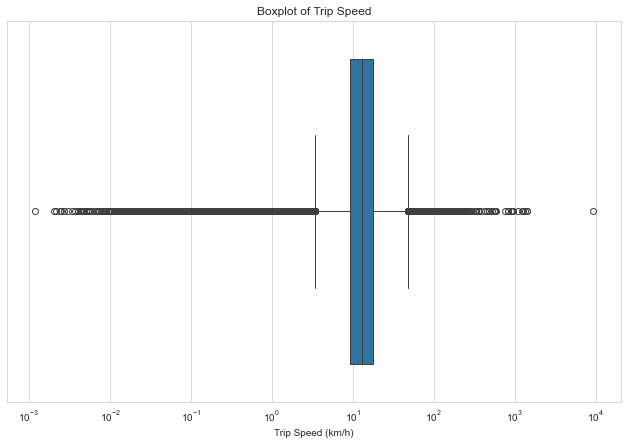

<Figure size 432x288 with 0 Axes>

In [111]:
plt.figure(figsize=(11, 7))
sns.boxplot(
    x=df_cleaned_4["speed_kmh"],
    log_scale=True
)

plt.xlabel('Trip Speed (km/h)')
plt.title('Boxplot of Trip Speed')
plt.savefig('./Plots/Plots[1]/trip_speed_boxplot.png')
plt.show()
plt.clf()

In [112]:
from scipy import stats

# Calculate Z-scores for the speed_kmh column
df_cleaned_4['z_score'] = stats.zscore(df_cleaned_4['speed_kmh'])

# Define the threshold for identifying outliers
z_threshold = 3

# Filter out the outliers in place
df_cleaned_4 = df_cleaned_4[df_cleaned_4['z_score'].abs() <= z_threshold]

# Drop the z_score column as it's no longer needed
df_cleaned_4 = df_cleaned_4.drop(columns=['z_score'])

# Display the cleaned DataFrame
df_cleaned_4

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,trip_distance_km,speed_kmh
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455,1.498,11.849
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663,1.804,9.798
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124,6.381,10.815
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429,1.485,12.458
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435,1.188,9.830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982,40.746,-73.995,40.740,N,778,1.224,5.665
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.001,40.747,-73.970,40.797,N,655,6.046,33.230
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959,40.769,-74.004,40.707,N,764,7.820,36.847
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982,40.749,-73.975,40.757,N,373,1.092,10.538


Passenger Count Outlier Detection and Removal

In [113]:
df_cleaned_4.passenger_count.value_counts()

1    1025583
2     208702
5      77379
3      59439
6      47801
4      28156
0         49
7          2
Name: passenger_count, dtype: int64

In [114]:
df_cleaned_4 = df_cleaned_4[df_cleaned_4['passenger_count'] != 0]
df_cleaned_4 = df_cleaned_4[df_cleaned_4['passenger_count'] <= 6]

df_cleaned_4.passenger_count.value_counts()

1    1025583
2     208702
5      77379
3      59439
6      47801
4      28156
Name: passenger_count, dtype: int64

Save cleaned dataframe to new .csv file.

In [115]:
df_cleaned_4.to_csv('./nyc_taxis/nyc_taxi_cleaned.csv', index=False)

### Question 2: Feature Engineering

Generate additional columns for at least these features (but you’re welcome to add more!):
- Distance of trip
- Day of week
- Average speed of trip

Note: Distance of trip and average speed of trip were already calculated in the Data Cleaning steps in Question 1.

In [116]:
df = pd.read_csv('./nyc_taxis/nyc_taxi_cleaned.csv')

display(df[['trip_distance_km', 'speed_kmh']])

,trip_distance_km,speed_kmh
0,1.498,11.849
1,1.804,9.798
2,6.381,10.815
3,1.485,12.458
4,1.188,9.830
...,...,...
1447055,1.224,5.665
1447056,6.046,33.230
1447057,7.820,36.847
1447058,1.092,10.538


In [117]:
# Extract day of the week

# Convert pickup and dropoff datetime columns to datetime objects
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Extract day of the week (0=Monday, 6=Sunday)
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Map integer values to day names
day_of_week_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}
df['day_of_week_str'] = df['day_of_week'].map(day_of_week_map)

# Additional feature: Extract hour of the day
df['pickup_hour'] = df['pickup_datetime'].dt.hour

# Additional feature: Time of day (morning, afternoon, evening)
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

df['time_of_day'] = df['pickup_hour'].apply(time_of_day)

# All new features
display(df[['trip_distance_km', 'speed_kmh', 'day_of_week', 'day_of_week_str', 'pickup_hour', 'time_of_day']].head())


,trip_distance_km,speed_kmh,day_of_week,day_of_week_str,pickup_hour,time_of_day
0,1.498,11.849,0,Monday,17,Evening
1,1.804,9.798,6,Sunday,0,Night
2,6.381,10.815,1,Tuesday,11,Morning
3,1.485,12.458,2,Wednesday,19,Evening
4,1.188,9.830,5,Saturday,13,Afternoon


### Question 3: Time-based

**[3.1]** Which day of the week is the most popular? Show plots to motivate your answer.

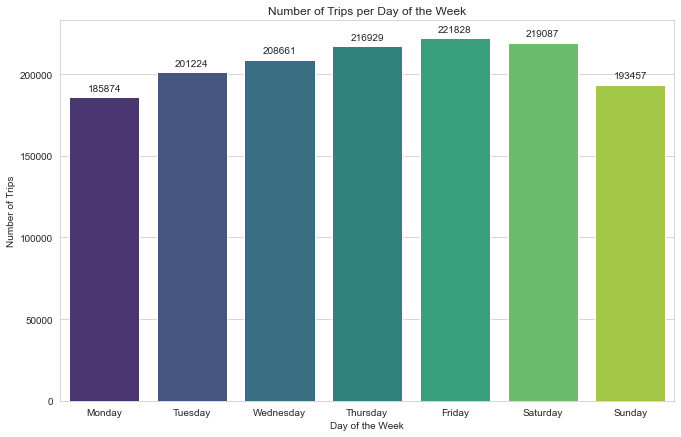

<Figure size 432x288 with 0 Axes>

In [118]:
day_of_week_counts = df['day_of_week'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(11, 7))
ax = sns.barplot(x=days, y=day_of_week_counts, hue=days, dodge=False, estimator="sum", palette='viridis')

# Add the total above each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.0f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.title('Number of Trips per Day of the Week')
plt.savefig('./Plots/Plots[3]/Plots[3.1]/num_of_trips_per_day_of_the_week.png')
plt.show()
plt.clf()

**[3.2]** What hour of the day is the most popular on each day? Plot a distribution of the hours and make observations and give possible suggestions for why the data looks like it does.

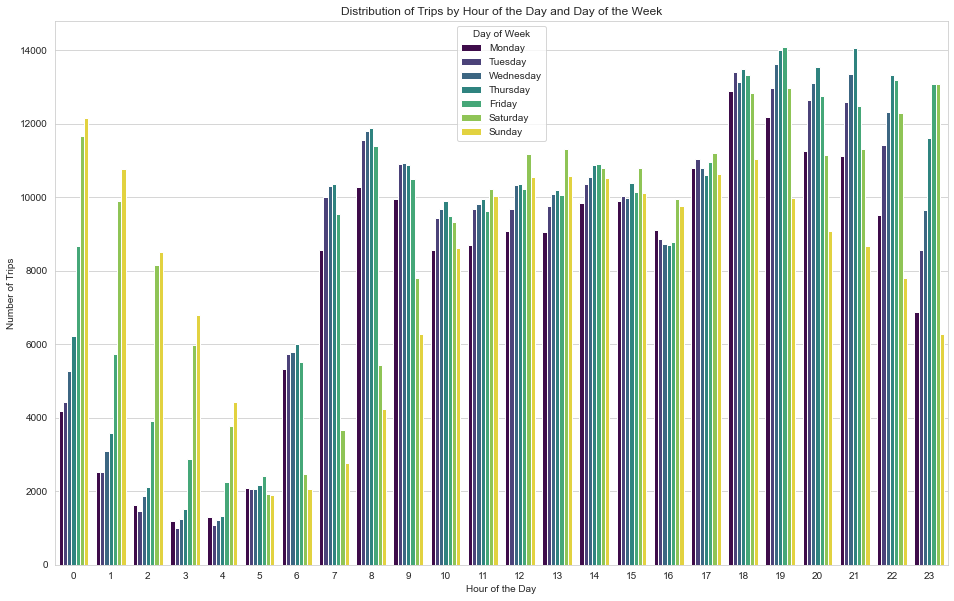

The most popular hour overall is: 18


<Figure size 432x288 with 0 Axes>

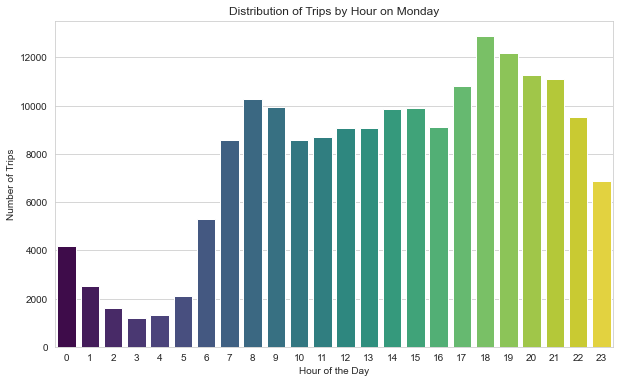

The most popular hour on Monday is: 18


<Figure size 432x288 with 0 Axes>

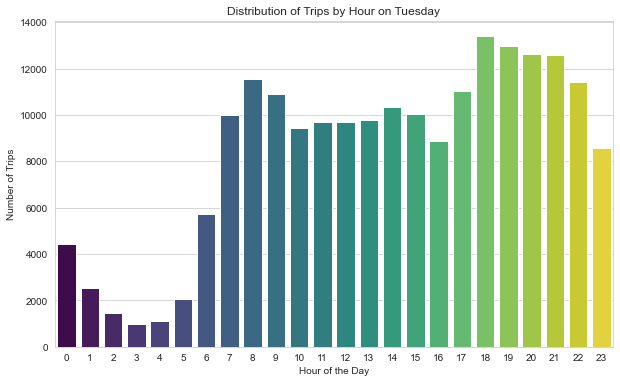

The most popular hour on Tuesday is: 18


<Figure size 432x288 with 0 Axes>

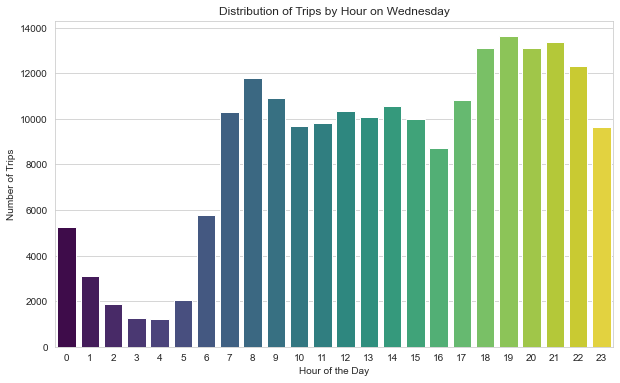

The most popular hour on Wednesday is: 19


<Figure size 432x288 with 0 Axes>

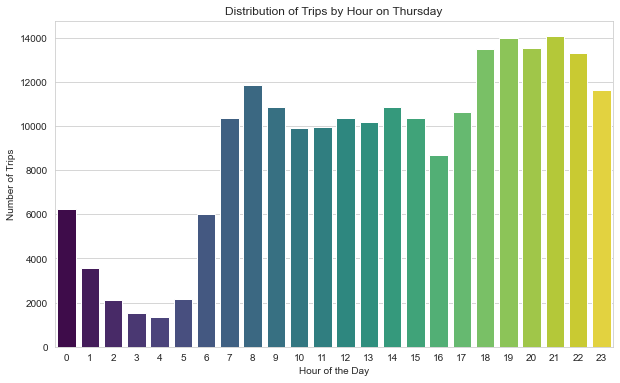

The most popular hour on Thursday is: 21


<Figure size 432x288 with 0 Axes>

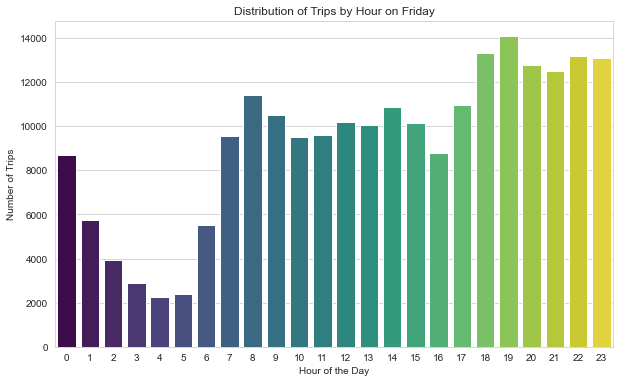

The most popular hour on Friday is: 19


<Figure size 432x288 with 0 Axes>

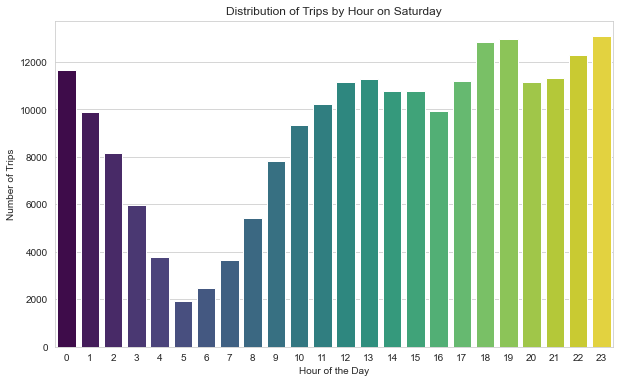

The most popular hour on Saturday is: 23


<Figure size 432x288 with 0 Axes>

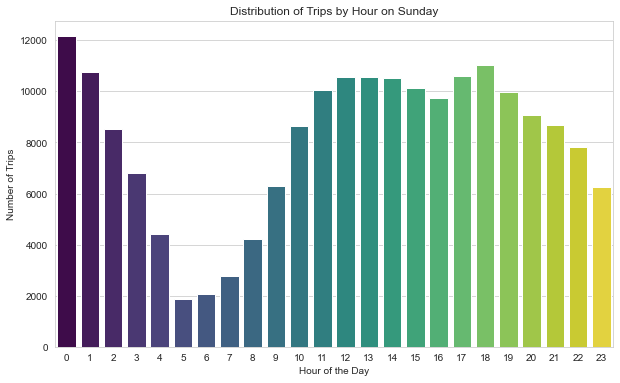

The most popular hour on Sunday is: 0


<Figure size 432x288 with 0 Axes>

In [119]:
output_folder = './Plots/Plots[3]/Plots[3.2]'
os.makedirs(output_folder, exist_ok=True)

# Define the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Overall distribution of trips by hour and day of the week
plt.figure(figsize=(16, 10))
sns.countplot(data=df, x='pickup_hour', hue='day_of_week', palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.title('Distribution of Trips by Hour of the Day and Day of the Week')
plt.legend(title='Day of Week', labels=days)
plt.savefig(os.path.join(output_folder, 'trips_by_hour_of_the_day_and_day_of_the_week.png'))
plt.show()
plt.clf()

# Print the most popular hour overall
most_popular_hour_overall = df['pickup_hour'].mode()[0]
print(f'The most popular hour overall is: {most_popular_hour_overall}')

# Individual plots for each day of the week
for i, day in enumerate(days):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df[df['day_of_week'] == i], x='pickup_hour', hue='pickup_hour', palette='viridis', legend=False)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Distribution of Trips by Hour on {day}')
    plt.savefig(os.path.join(output_folder, f'trips_by_hour_on_{day.lower()}.png'))
    plt.show()
    plt.clf()
    
    # Print the most popular hour for each day
    most_popular_hour = df[df['day_of_week'] == i]['pickup_hour'].mode()[0]
    print(f'The most popular hour on {day} is: {most_popular_hour}')

**[3.3]** Investigate the differences between weekdays and weekends. What would account for this? 

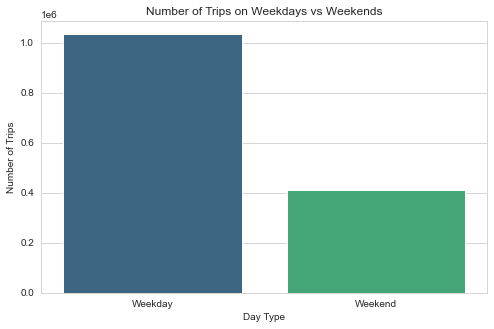

<Figure size 432x288 with 0 Axes>

In [120]:
# Create a new column indicating whether the day is a weekend
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Compare trips on weekdays vs weekends
weekend_vs_weekday_counts = df['is_weekend'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Weekday', 'Weekend'], y=weekend_vs_weekday_counts, hue=['Weekday', 'Weekend'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Weekdays vs Weekends')
plt.savefig('./Plots/Plots[3]/Plots[3.3]/num_trips_on_weekdays_vs_weekends.png')
plt.show()
plt.clf()

The bar plot visualizes the number of trips on weekdays compared to weekends. The data shows that significantly more trips occur on weekdays than on weekends. There are several factors that could account for this difference:

1. **Work and School Commutes**:
   - Weekdays typically have higher trip volumes because of regular work and school commutes. People travel to and from work, school, and other routine activities, contributing to the increased number of trips.

2. **Business Activity**:
   - Many businesses operate primarily during weekdays, which results in more trips for meetings, deliveries, and other business-related activities. This could explain the higher trip count on weekdays.

3. **Leisure vs. Routine Travel**:
   - Weekends are generally reserved for leisure activities, which may not require as many short or frequent trips as weekdays. Additionally, many people prefer to stay home or engage in fewer activities during weekends, reducing the overall demand for transportation.

4. **Public Transportation and Ride-Hailing Services**:
   - The availability and demand for public transportation and ride-hailing services might also differ between weekdays and weekends. On weekdays, people might rely more on these services to get to work or school, whereas on weekends, they may opt for alternative transportation or stay in, reducing trip numbers.

**[3.4]** Look at how these patterns change on the major holidays (do they change?). Look at the following: St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, Martin Luther King Day. Make sure you use the correct dates for these for the relevant year.

Steps/Explanation for [3.4] Analysis of Trip Patterns on Major Holidays

Objective: Analyze how trip patterns change on major holidays compared to regular days. The holidays of interest are St. Patrick’s Day, Easter, Memorial Day, Valentine’s Day, and Martin Luther King Day in 2016. Specifically, we want to determine if there are significant differences in the hourly distribution of trips and cumulative trip patterns on these holidays.

1. Identify Major Holidays in the Dataset:
    - We first define the dates of the major holidays in 2016 and convert these dates to datetime objects.
The dataset is then processed to include a new column, is_holiday, which indicates whether a trip occurred on a major holiday.

2. Overall Comparison of Trip Counts:
    - A bar plot is created to compare the total number of trips on holidays versus non-holidays. This provides an initial overview of how trip volumes differ on these special days.

3. Hourly Distribution of Trips on Each Holiday:
    - For each holiday, we plot the hourly distribution of trips. This allows us to visualize how trip activity varies throughout the day on each holiday.
    - We compare this distribution with regular days of the same weekday (e.g., compare Martin Luther King Day with other Mondays) to determine whether the holiday significantly alters travel behavior.
    - Additionally, we ensure that the comparison day (one week before the holiday) is not another major holiday to maintain a fair comparison.

4. Cumulative Distribution Function (CDF) Analysis:
    - We plot the Cumulative Distribution Function (CDF) for trips on each holiday and compare it with the CDF for trips on a regular day one week before the holiday. The CDF shows how trips accumulate over the course of the day, highlighting whether trips are more concentrated in the morning, afternoon, or evening on holidays versus regular days.
    - This analysis is crucial for understanding whether travel patterns are more spread out or clustered at certain times during holidays compared to typical weekdays or weekends.

Conclusion:
- This multi-faceted approach provides a comprehensive analysis of how trip patterns change on major holidays. By comparing hourly distributions and cumulative distributions, we gain valuable insights into whether holidays significantly affect travel behavior in New York City. These insights could be useful for understanding traffic management, service demand, and urban planning during holidays.


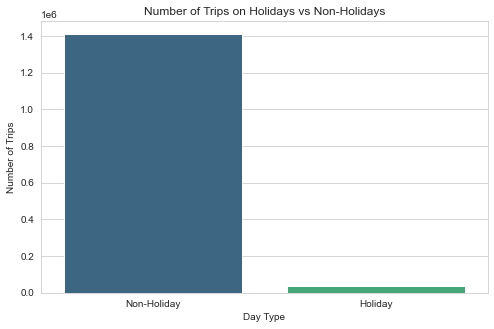

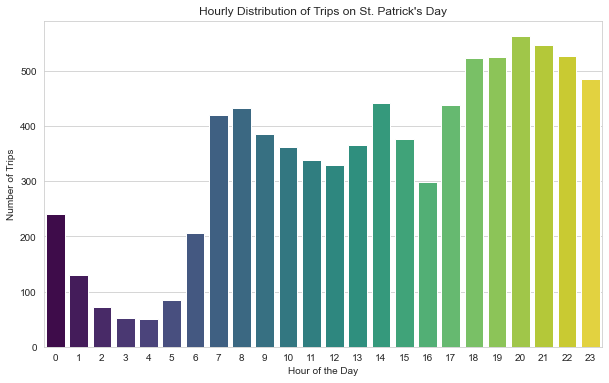

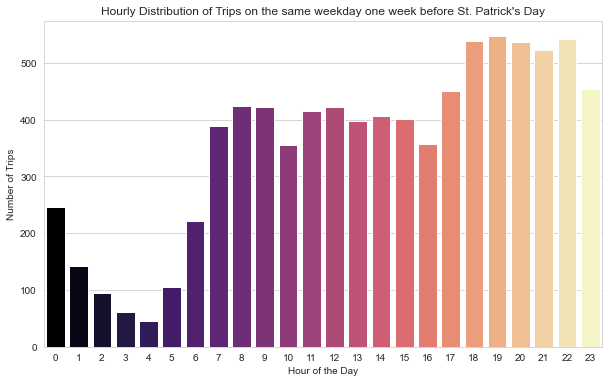

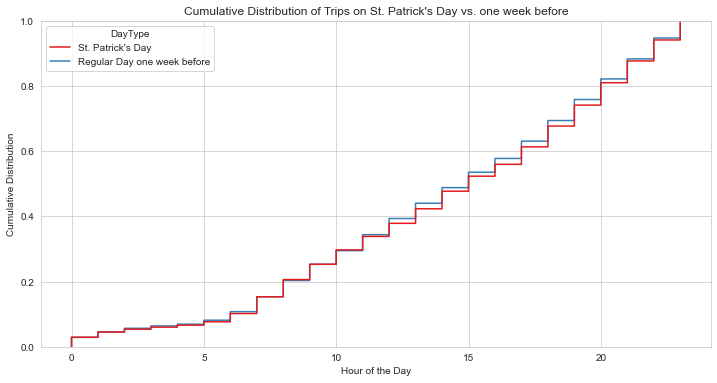

<Figure size 432x288 with 0 Axes>

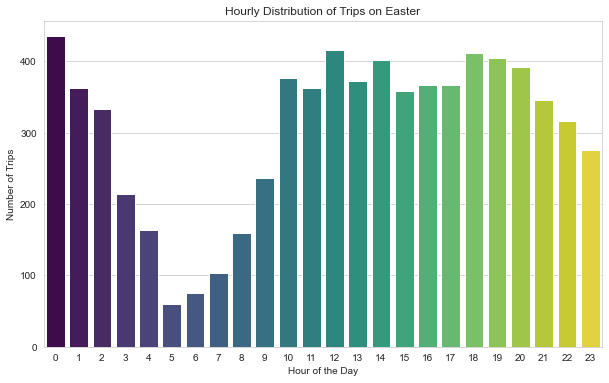

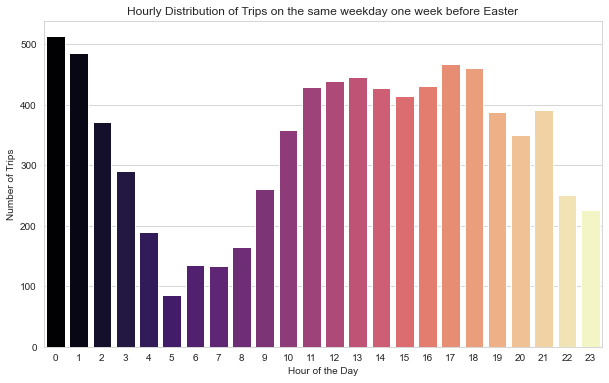

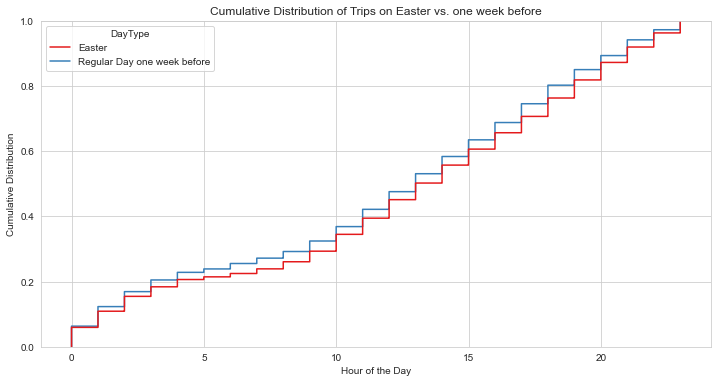

<Figure size 432x288 with 0 Axes>

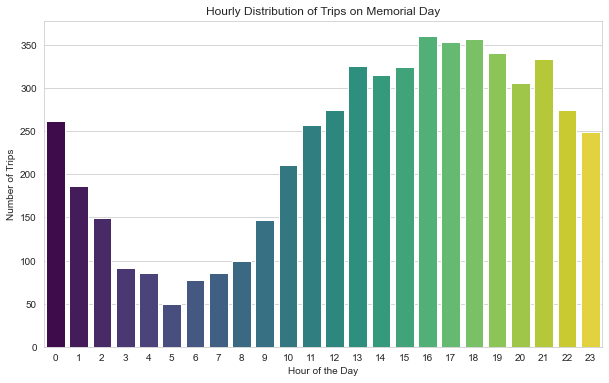

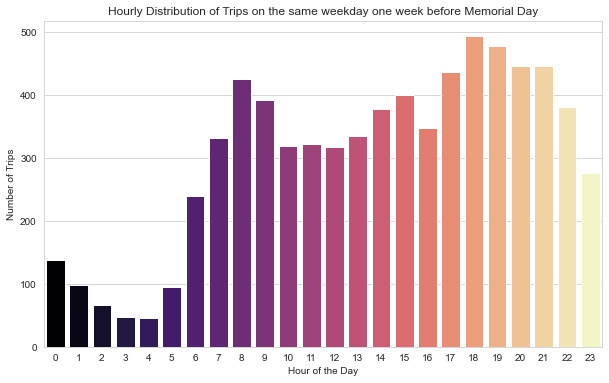

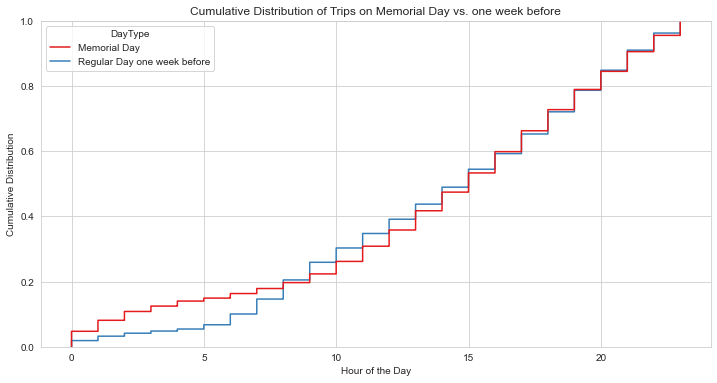

<Figure size 432x288 with 0 Axes>

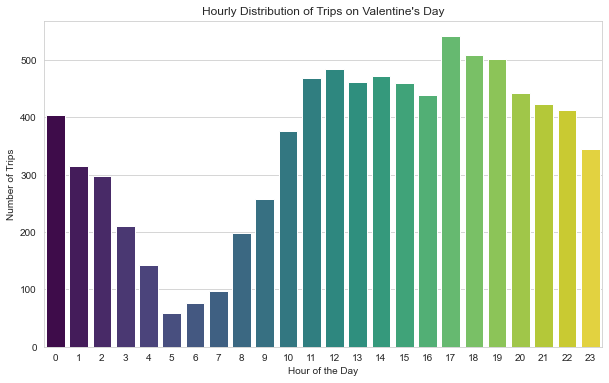

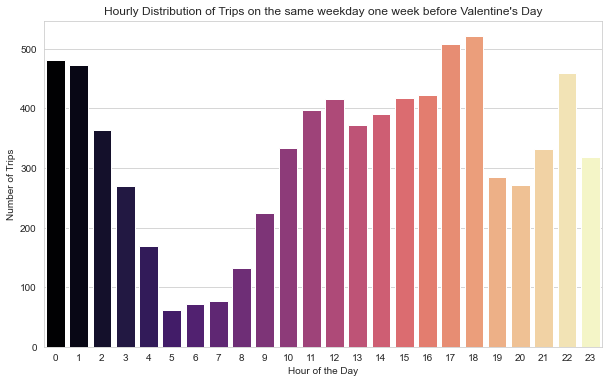

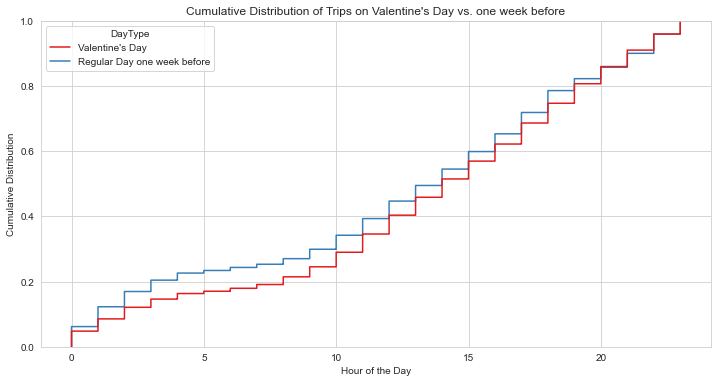

<Figure size 432x288 with 0 Axes>

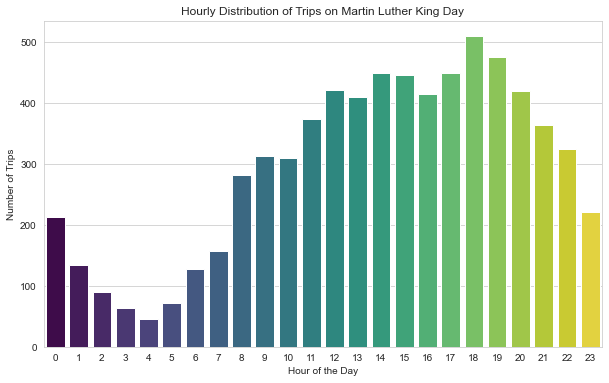

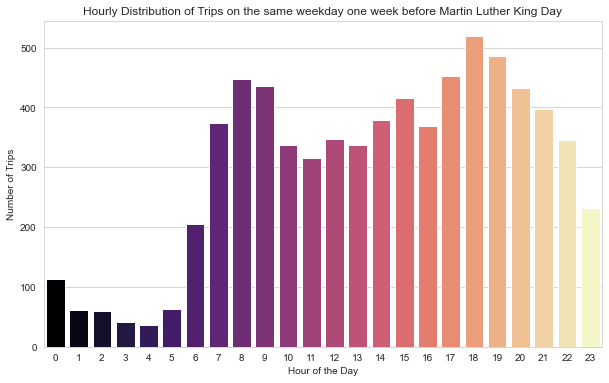

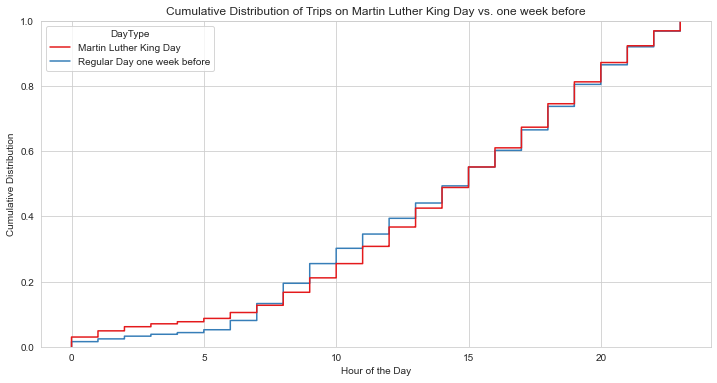

<Figure size 432x288 with 0 Axes>

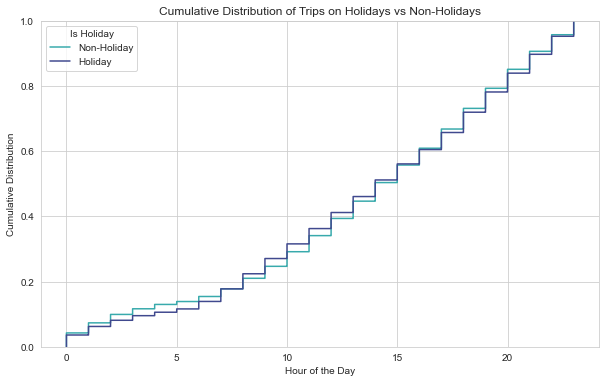

In [121]:

output_folder = "./Plots/Plots[3]/Plots[3.4]"

# Define major holidays in 2016
holidays_2016 = {
    'St. Patrick\'s Day': '2016-03-17',
    'Easter': '2016-03-27',
    'Memorial Day': '2016-05-30',
    'Valentine\'s Day': '2016-02-14',
    'Martin Luther King Day': '2016-01-18'
}

# Convert holiday dates to datetime objects
holiday_dates = pd.to_datetime(list(holidays_2016.values()))

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Create a new column indicating whether the trip occurred on a major holiday
df['is_holiday'] = df['pickup_datetime'].dt.normalize().isin(holiday_dates)

# Compare trip counts on holidays vs non-holidays
holiday_vs_nonholiday_counts = df['is_holiday'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=['Non-Holiday', 'Holiday'], y=holiday_vs_nonholiday_counts, hue=['Non-Holiday', 'Holiday'], dodge=False, estimator="sum", palette='viridis')
plt.xlabel('Day Type')
plt.ylabel('Number of Trips')
plt.title('Number of Trips on Holidays vs Non-Holidays')
# Save the figure
plt.savefig(os.path.join(output_folder, "trips_holidays_vs_nonholidays.png"))
plt.show()

# Analyze differences during holidays
for holiday, date in holidays_2016.items():
    holiday_data = df[df['pickup_datetime'].dt.date == pd.to_datetime(date).date()]
    
    # Calculate the date exactly one week before
    one_week_before_date = pd.to_datetime(date) - pd.Timedelta(weeks=1)
    
    # Ensure the date one week before is not a major holiday
    while one_week_before_date in holiday_dates:
        one_week_before_date -= pd.Timedelta(weeks=1)
    
    one_week_before_data = df[df['pickup_datetime'].dt.date == one_week_before_date.date()]

    plt.figure(figsize=(10, 6))
    sns.countplot(data=holiday_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='viridis')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on {holiday}')
    plt.savefig(os.path.join(output_folder, f"{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Compare to the date exactly one week before
    plt.figure(figsize=(10, 6))
    sns.countplot(data=one_week_before_data, x='pickup_hour', hue='pickup_hour', legend=False, palette='magma')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Trips')
    plt.title(f'Hourly Distribution of Trips on the same weekday one week before {holiday}')
    plt.savefig(os.path.join(output_folder, f"one_week_before_{holiday.replace(' ', '_').lower()}_hourly_distribution.png"))
    plt.show()

    # Step 6: Cumulative distribution function (CDF)
    combined_data = pd.concat([holiday_data.assign(DayType=holiday), one_week_before_data.assign(DayType='Regular Day one week before')])

    plt.figure(figsize=(12, 6))
    sns.ecdfplot(data=combined_data, x='pickup_hour', hue='DayType', palette='Set1')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Cumulative Distribution')
    plt.title(f'Cumulative Distribution of Trips on {holiday} vs. one week before')
    plt.savefig(os.path.join(output_folder, f"cdf_{holiday.replace(' ', '_').lower()}_vs_one_week_before.png"))
    plt.show()

    plt.clf()

# Holiday vs. Non-Holiday Cumulative Distribution
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df, x='pickup_hour', hue='is_holiday', palette='mako')
plt.xlabel('Hour of the Day')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Trips on Holidays vs Non-Holidays')
plt.legend(title='Is Holiday', labels=['Non-Holiday', 'Holiday'])
plt.savefig(os.path.join(output_folder, "cdf_holidays_vs_nonholidays.png"))
plt.show()

**Analyzing the Differences Between Holiday and Non-Holiday Trip Patterns**

Based on the CDF plots, we can observe several key differences in trip patterns between holidays and non-holidays:

1. **Delayed Starts:** The CDF for holidays consistently starts lower than the CDF for non-holidays, indicating fewer trips in the early hours on holidays. This suggests a delayed start to the day compared to regular days.
2. **Extended Evening Hours:** The CDF for holidays consistently ends higher than the CDF for non-holidays, indicating a higher proportion of trips occurring later in the evening on holidays. This suggests extended activities or a different pattern of evening travel.
3. **Mid-Day Similarity:** While the early and late hours show significant differences, the lines for holidays and non-holidays tend to converge around the mid-day and afternoon hours. This suggests that trip patterns during these times are relatively similar, with less variation between holidays and non-holidays.

**Overall, the analysis indicates that while the general pattern of trip accumulation over the day is similar for holidays and non-holidays, there are notable differences in the timing of trips.** Holidays are characterized by delayed starts and extended evening hours, suggesting that social and leisure activities play a significant role in shaping travel behavior on these days.

**[3.5]** How does the average speed of trips change throughout the day? What time of day are trips fastest? Show plots to motivate your answer.

**Steps:**
- Calculate Average Speed per Hour: Group the data by the hour of the day and calculate the mean speed for each hour.
- Plot the Average Speed: Create a line plot to visualize how average speed changes throughout the day.
- Identify the Fastest Time of Day: Highlight the hour(s) where the average speed is the highest.

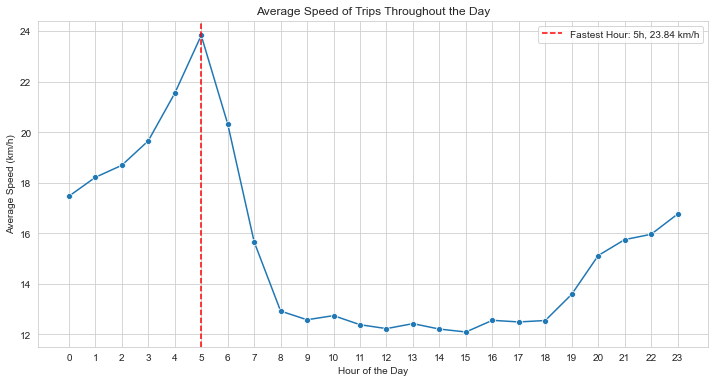

The fastest time of day is around 5:00 with an average speed of 23.84 km/h.


<Figure size 432x288 with 0 Axes>

In [132]:
# Calculate the average speed per hour
avg_speed_per_hour = df.groupby('pickup_hour')['speed_kmh'].mean()

# Step 2: Plot the average speed throughout the day
plt.figure(figsize=(12, 6))
sns.lineplot(x=avg_speed_per_hour.index, y=avg_speed_per_hour.values, marker='o')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Speed (km/h)')
plt.title('Average Speed of Trips Throughout the Day')
plt.xticks(range(0, 24))  # Ensuring all hours are shown on the x-axis
plt.grid(True)

# Highlight the hour(s) with the highest average speed
fastest_hour = avg_speed_per_hour.idxmax()
fastest_speed = avg_speed_per_hour.max()
plt.axvline(x=fastest_hour, color='red', linestyle='--', label=f'Fastest Hour: {fastest_hour}h, {fastest_speed:.2f} km/h')
plt.legend()

plt.savefig('./Plots/Plots[3]/Plots[3.5]/average_speed_throughout_day.png')

plt.show()
plt.clf()

print(f"The fastest time of day is around {fastest_hour}:00 with an average speed of {fastest_speed:.2f} km/h.")
